In [1]:
import tensorflow as tf
from losses import binary_crossentropy 
from tensorflow.keras.utils import plot_model
from eunet import build_EUNet, get_callbacks
from loading_preprocessing_dataset import prepare_dataset, create_dataset
from loading_preprocessing_dataset import gaussian_filter, find_threshold_otsu, binary
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2229181180059159970,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6776234719427135972
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6286548672
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5910961539863240735
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7304962232251738514
 physical_device_desc: "device: XLA_GPU device"]

## 1. Build Efficient U-Net 

In [3]:
model = build_EUNet(number_classes = 1, input_height = 256, input_width = 256)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 128, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]          

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0145783 to fit



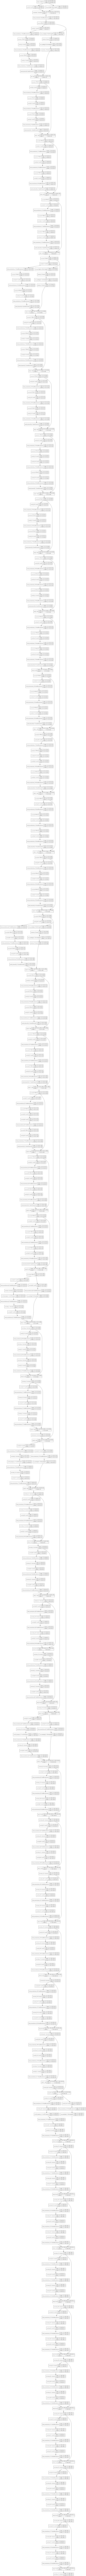

In [5]:
plot_model( model,
            to_file='model.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=4048)

In [6]:
model.compile("adam", loss=binary_crossentropy)

## 2. Load and Prepare Train, Validation and Test Datasets

In [7]:
Train_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/"
Valid_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/"
Test_Dataset_dir = "/media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/"

In [8]:
train_sb_dir, train_gt_dir, sb_train_list, gt_train_list = prepare_dataset(Train_Dataset_dir) #load Satellite und Ground Truths Data
valid_sb_dir, valid_gt_dir, sb_valid_list, gt_valid_list = prepare_dataset(Valid_Dataset_dir)
test_sb_dir, test_gt_dir, sb_test_list, gt_test_list = prepare_dataset(Test_Dataset_dir)

Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_SB/
Number of  ground truths: 6876

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/train/Croped_GT/
Number der satellien images: 6876
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_SB/
Number of  ground truths: 756

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/valid/Croped_GT/
Number der satellien images: 756
*********************************************
Satellite Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_SB/
Number of  ground truths: 774

Ground Truths Directory: /media/rima/C/Datasets/cut_tirol/Klein_Dataset2/test/Croped_GT/
Number der satellien images: 774
*********************************************


In [9]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
number_batches = 32 #
buffer_size =  20000

In [10]:
train_dataset = create_dataset(sb_train_list, gt_train_list, buffer_size =  buffer_size, number_batche = number_batches )
validation_dataset = create_dataset(sb_valid_list, gt_valid_list, buffer_size =  buffer_size, number_batche = number_batches )
test_dataset = create_dataset(sb_test_list, gt_test_list, buffer_size =  buffer_size, number_batche = number_batches )

(32, 256, 256, 3) (32, 256, 256, 1)


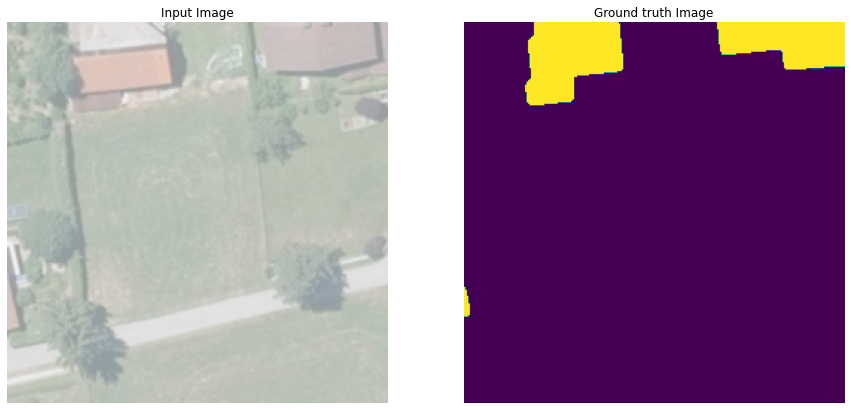

In [16]:
for SB, GT in validation_dataset.take(1):
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,]]
    title = ['Input Image', 'Ground truth Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()

## 3. Train Model

In [17]:
callbacks_list = get_callbacks()
model.fit(train_dataset,
          epochs= 100,
          verbose=1,
          callbacks=callbacks_list,
          validation_data= validation_dataset)

Epoch 1/100
215/215 [==============================] - ETA: 0s - loss: 0.9055
Epoch 00001: val_loss improved from inf to 0.65739, saving model to ./models/E_UNet_(12-31-2020 , 00:17:06)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 00:17:06)/assets
215/215 [==============================] - 127s 590ms/step - loss: 0.9055 - val_loss: 0.6574
Epoch 2/100
215/215 [==============================] - ETA: 0s - loss: 0.6443
Epoch 00002: val_loss improved from 0.65739 to 0.59420, saving model to ./models/E_UNet_(12-31-2020 , 00:17:06)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 00:17:06)/assets
215/215 [==============================] - 122s 570ms/step - loss: 0.6443 - val_loss: 0.5942
Epoch 3/100
215/215 [==============================] - ETA: 0s - loss: 0.5860
Epoch 00003: val_loss improved from 0.59420 to 0.53250, saving model to ./models/E_UNet_(12-31-2020 , 00:17:06)
INF

INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 00:17:06)/assets
215/215 [==============================] - 125s 581ms/step - loss: 0.2790 - val_loss: 0.1986
Epoch 23/100
215/215 [==============================] - ETA: 0s - loss: 0.2689
Epoch 00023: val_loss improved from 0.19862 to 0.19139, saving model to ./models/E_UNet_(12-31-2020 , 00:17:06)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 00:17:06)/assets
215/215 [==============================] - 125s 584ms/step - loss: 0.2689 - val_loss: 0.1914
Epoch 24/100
215/215 [==============================] - ETA: 0s - loss: 0.2637
Epoch 00024: val_loss improved from 0.19139 to 0.18472, saving model to ./models/E_UNet_(12-31-2020 , 00:17:06)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 00:17:06)/assets
215/215 [==============================] - 125s 580ms/step - loss: 0.2637 - val_loss: 0.1847
Epoch 25/100
215/215 [==============================] - ETA: 0s - loss: 0.2545
Epoch 00025: v

Epoch 53/100
215/215 [==============================] - ETA: 0s - loss: 0.1703
Epoch 00053: val_loss did not improve from 0.13505
215/215 [==============================] - 89s 414ms/step - loss: 0.1703 - val_loss: 0.1519
Epoch 54/100
215/215 [==============================] - ETA: 0s - loss: 0.1689
Epoch 00054: val_loss did not improve from 0.13505
215/215 [==============================] - 89s 413ms/step - loss: 0.1689 - val_loss: 0.1382
Epoch 55/100
215/215 [==============================] - ETA: 0s - loss: 0.1670
Epoch 00055: val_loss did not improve from 0.13505
215/215 [==============================] - 89s 413ms/step - loss: 0.1670 - val_loss: 0.1435
Epoch 56/100
215/215 [==============================] - ETA: 0s - loss: 0.1661
Epoch 00056: val_loss did not improve from 0.13505
215/215 [==============================] - 89s 413ms/step - loss: 0.1661 - val_loss: 0.1446
Epoch 57/100
215/215 [==============================] - ETA: 0s - loss: 0.1640
Epoch 00057: val_loss did not imp

Epoch 88/100
215/215 [==============================] - ETA: 0s - loss: 0.1388
Epoch 00088: val_loss did not improve from 0.12905
215/215 [==============================] - 89s 413ms/step - loss: 0.1388 - val_loss: 0.1379
Epoch 89/100
215/215 [==============================] - ETA: 0s - loss: 0.1363
Epoch 00089: val_loss did not improve from 0.12905
215/215 [==============================] - 89s 414ms/step - loss: 0.1363 - val_loss: 0.1388
Epoch 90/100
215/215 [==============================] - ETA: 0s - loss: 0.1363
Epoch 00090: val_loss improved from 0.12905 to 0.12831, saving model to ./models/E_UNet_(12-31-2020 , 00:17:06)
INFO:tensorflow:Assets written to: ./models/E_UNet_(12-31-2020 , 00:17:06)/assets
215/215 [==============================] - 126s 585ms/step - loss: 0.1363 - val_loss: 0.1283
Epoch 91/100
215/215 [==============================] - ETA: 0s - loss: 0.1356
Epoch 00091: val_loss did not improve from 0.12831
215/215 [==============================] - 89s 414ms/step - 

In [18]:
model_path = "/home/amir/Desktop/Tree Counting/Counting Trees/models/UNet_(11-26-2020 , 19:51:28)"

# load model
model = load_model("./models/E_UNet_(12-31-2020 , 00:17:06)")

## 4. Test Model

(32, 256, 256, 3) (32, 256, 256, 1)


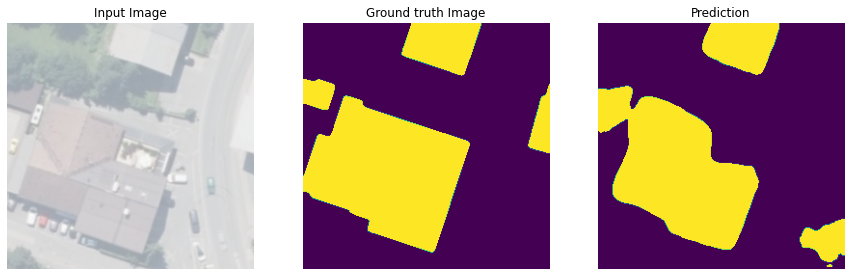

(32, 256, 256, 3) (32, 256, 256, 1)


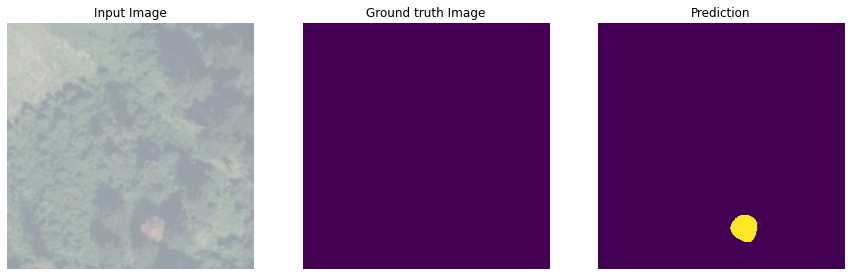

(32, 256, 256, 3) (32, 256, 256, 1)


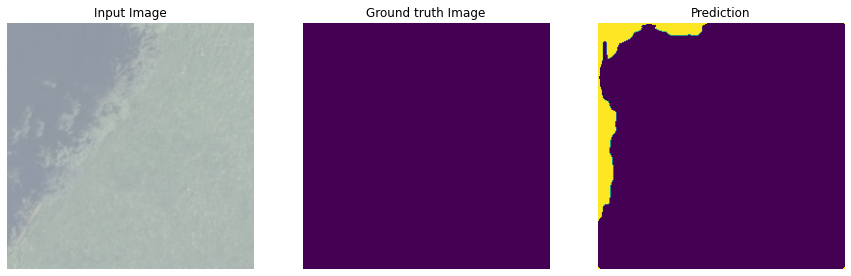

(32, 256, 256, 3) (32, 256, 256, 1)


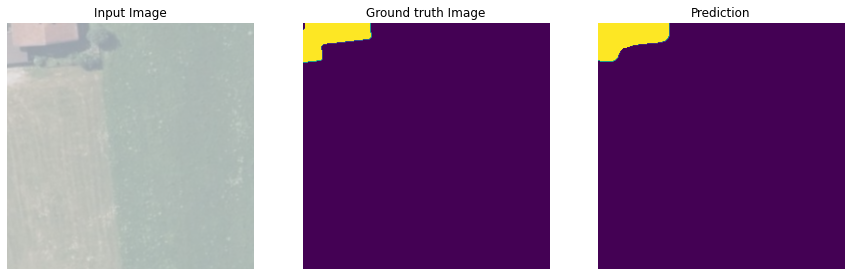

(32, 256, 256, 3) (32, 256, 256, 1)


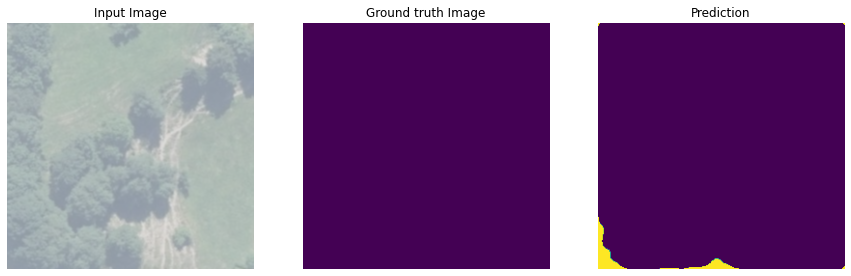

(32, 256, 256, 3) (32, 256, 256, 1)


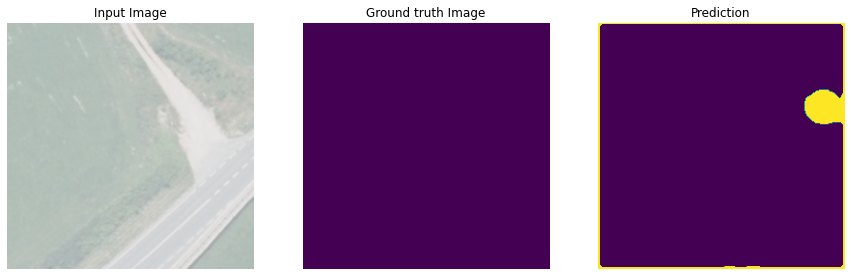

(32, 256, 256, 3) (32, 256, 256, 1)


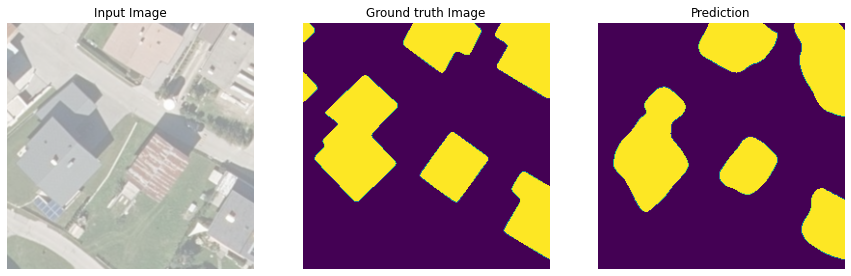

(32, 256, 256, 3) (32, 256, 256, 1)


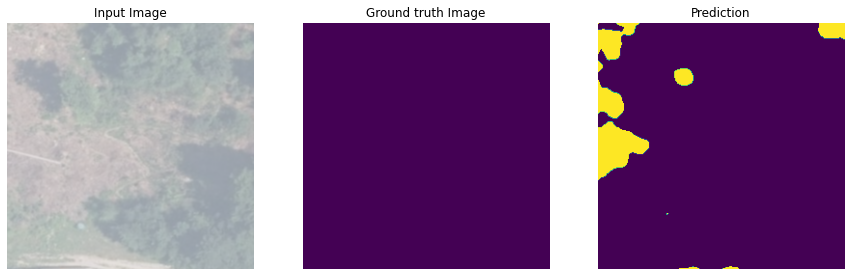

(32, 256, 256, 3) (32, 256, 256, 1)


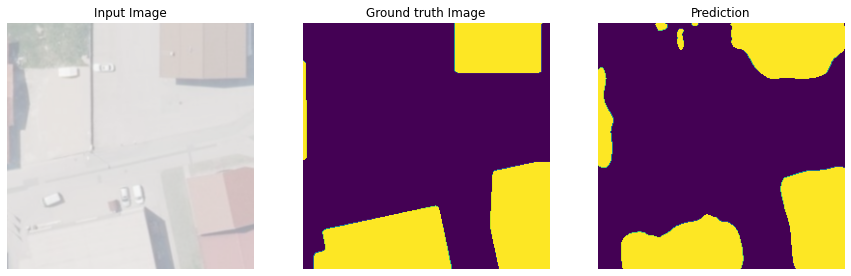

(32, 256, 256, 3) (32, 256, 256, 1)


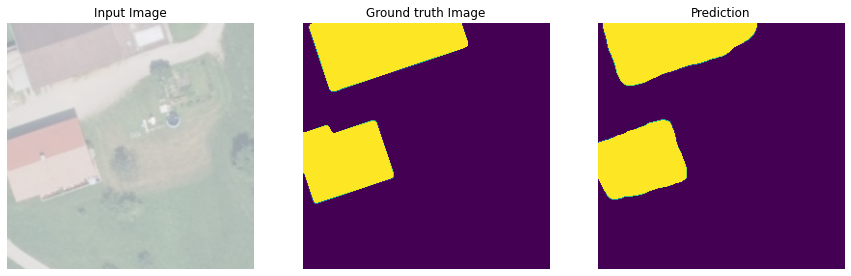

(32, 256, 256, 3) (32, 256, 256, 1)


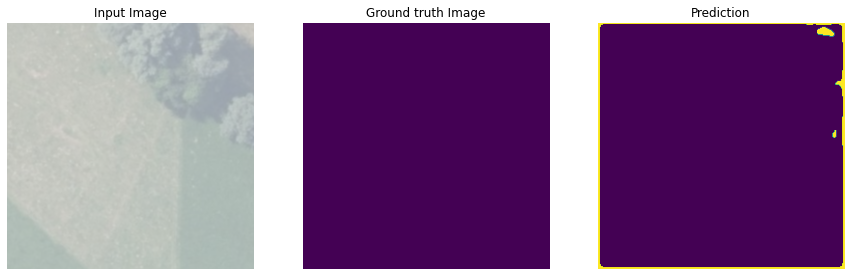

(32, 256, 256, 3) (32, 256, 256, 1)


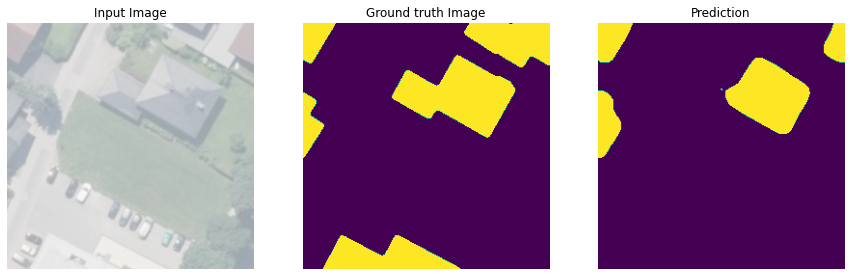

(32, 256, 256, 3) (32, 256, 256, 1)


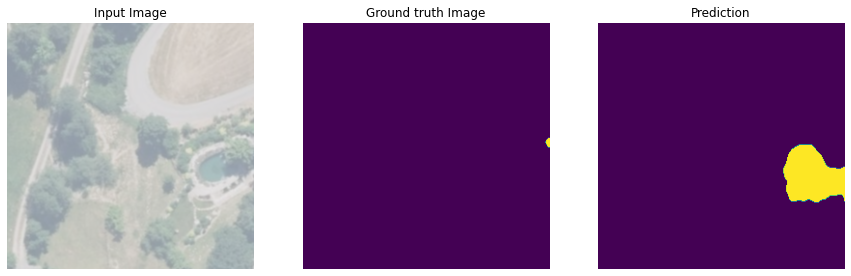

(32, 256, 256, 3) (32, 256, 256, 1)


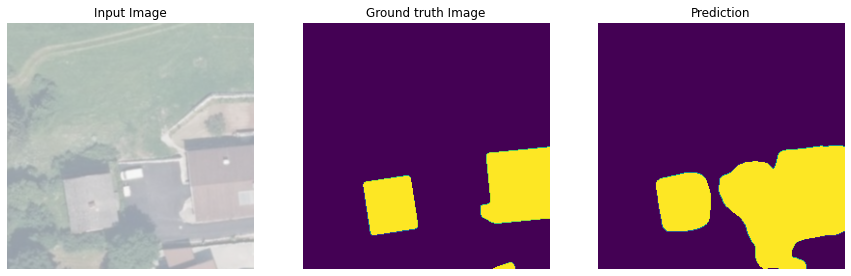

(32, 256, 256, 3) (32, 256, 256, 1)


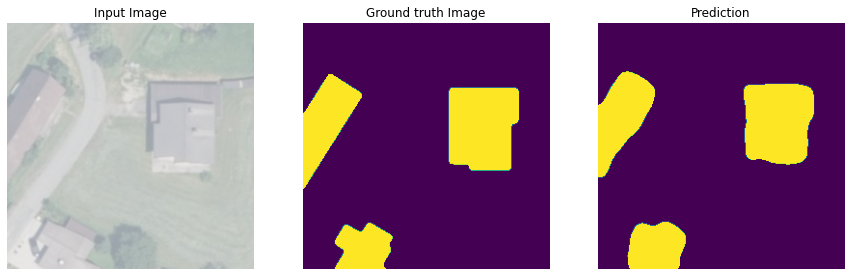

(32, 256, 256, 3) (32, 256, 256, 1)


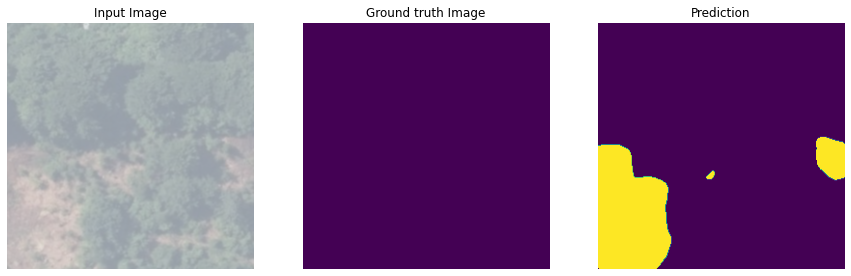

(32, 256, 256, 3) (32, 256, 256, 1)


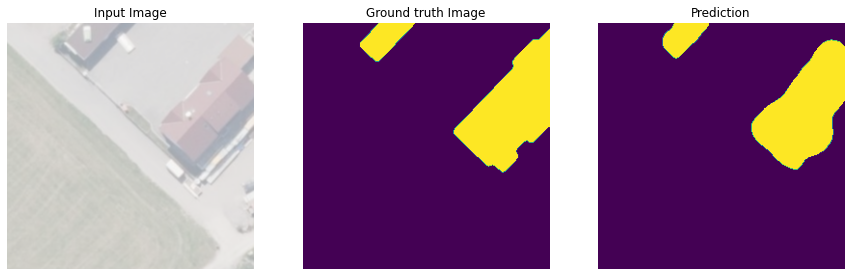

(32, 256, 256, 3) (32, 256, 256, 1)


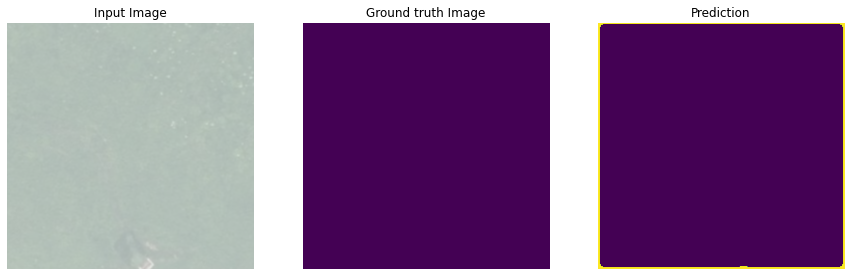

(32, 256, 256, 3) (32, 256, 256, 1)


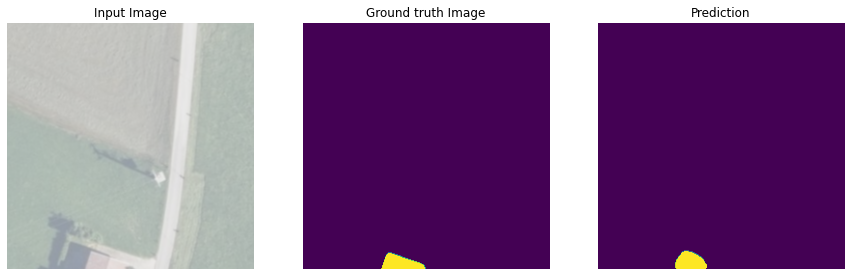

(32, 256, 256, 3) (32, 256, 256, 1)


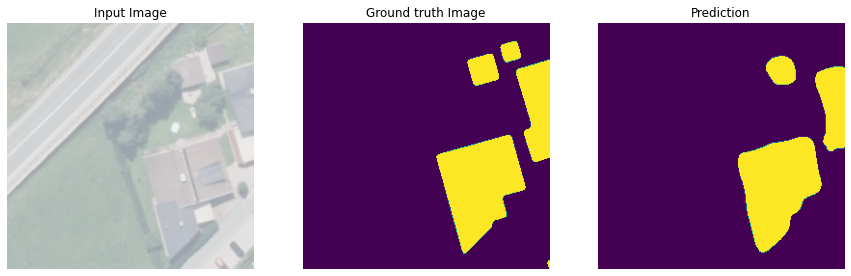

(32, 256, 256, 3) (32, 256, 256, 1)


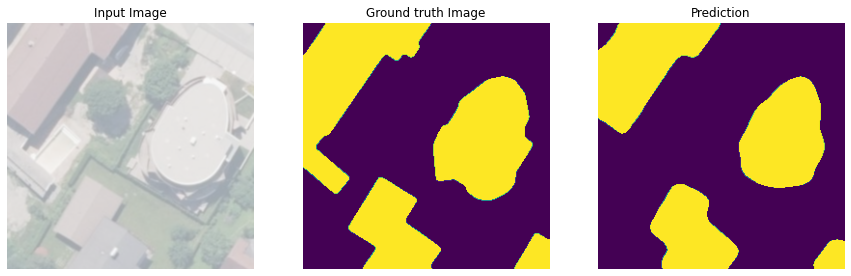

(32, 256, 256, 3) (32, 256, 256, 1)


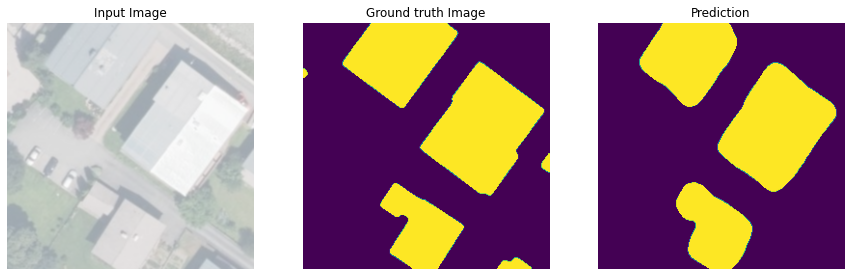

(32, 256, 256, 3) (32, 256, 256, 1)


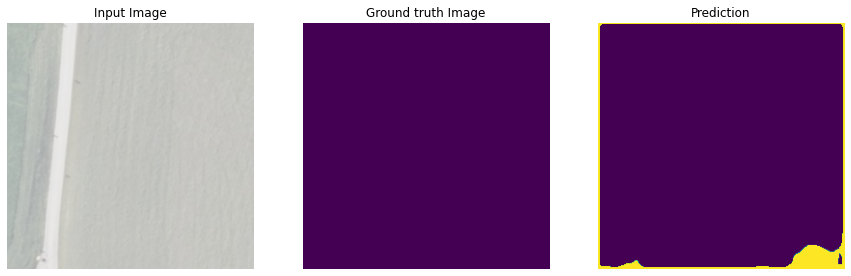

(32, 256, 256, 3) (32, 256, 256, 1)


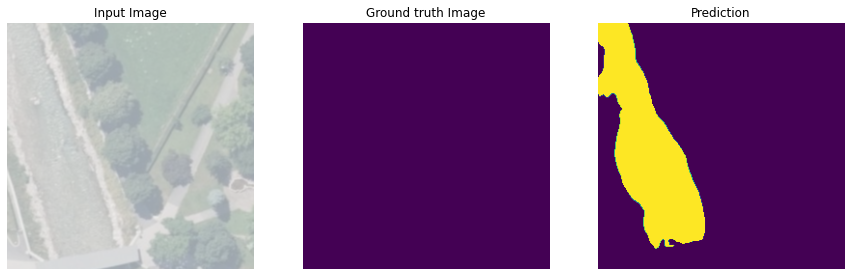

(6, 256, 256, 3) (6, 256, 256, 1)


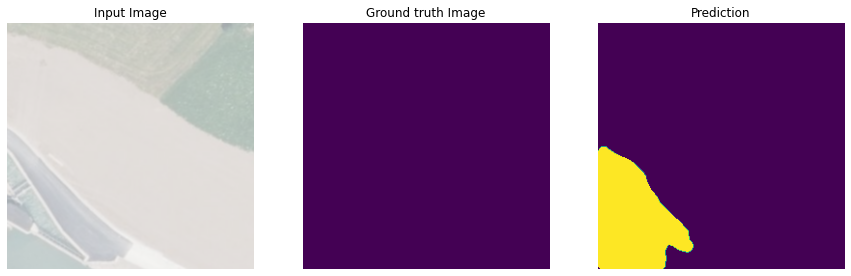

In [20]:
for SB, GT in test_dataset.take(30):
    prediction = model.predict(SB)
    plt.figure(figsize=(15,15))
    print(SB.shape, GT.shape)
    
    guass_img = gaussian_filter(prediction[0,:,:,:,], sigma =2)
    threshold =  find_threshold_otsu(guass_img)
    binary_prediction = binary(guass_img, threshold, max_value = 1)
    
    display_list=[SB[0,:,:,:,],GT[0,:,:,:,],binary_prediction]
    title = ['Input Image', 'Ground truth Image',"Prediction"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*.5+.5 )
        plt.axis('off')
    plt.show()